# Exploratory Data Analysis

In [1]:
from glob import glob
import pandas as pd
import sqlite3
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [2]:
all_labels = {}
i = 0
for line in open("./iNaturalist/images/Poison Ivy/classes.txt"):
    all_labels[str(i)] = line.strip()
    i += 1

object_counts = {}
for k, v in all_labels.items():
    pattern = "./iNaturalist/images/" + v + "/*.txt"
    labels = glob(pattern)
    labels.remove("./iNaturalist/images/" + v + "\\classes.txt")
    for f in labels:
        for line in open(f):
            label_id = line.split(" ")[0]
            object_counts[all_labels[label_id]] = object_counts.get(all_labels[label_id], 0) + 1
object_counts

{'Poison Ivy': 3339, 'Virginia Creeper': 766}

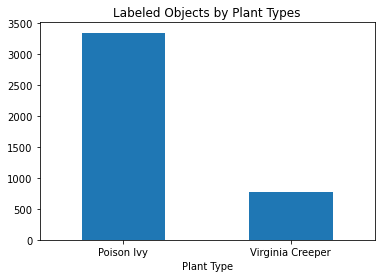

In [3]:
object_counts_df = pd.DataFrame.from_dict(object_counts, orient="index", columns=["Objects"]).reset_index().rename(columns={"index":"Plant Type"}).reset_index(drop=True)
object_counts_df.plot.bar(x="Plant Type", y="Objects", rot=0, legend=False, title="Labeled Objects by Plant Types");

In [4]:
images = glob("./iNaturalist/images/Poison Ivy/*.j*")
labels = glob("./iNaturalist/images/Poison Ivy/*.txt")
labels.remove("./iNaturalist/images/Poison Ivy\\classes.txt")
n_images = len(images)
n_labeled = len(labels)
conn = sqlite3.connect("images.db")
c = conn.cursor()

n_objects = {}
record_ids = set()
max_record = 0
month_counts = {}
all_month_counts = {}
coords = []
min_record_id = 9999999

for f in labels:
    objects = sum(1 for line in open(f))
    n_objects[objects] = n_objects.get(objects, 0) + 1
    record_id = int(f.split("\\")[-1].split(".txt")[0])
    record_ids.add(record_id)
    if record_id > max_record:
        max_record = record_id

c.execute("SELECT * FROM images WHERE label LIKE 'Poison Ivy'")

for row in c.fetchall():
    date = row[6]
    month = date.split("-")[1]
    all_month_counts[month] = all_month_counts.get(month, 0) + 1
    if row[0] < min_record_id:
        min_record_id = row[0]
    if row[0] in record_ids:
        coords.append({"lat":row[4], "lon":row[5]})        
        month_counts[month] = month_counts.get(month, 0) + 1
        
n_images_reviewed = max_record - min_record_id

print(str(round(n_images_reviewed / n_images * 100, 1)) + "% of the images are reviewed ("+str(n_images_reviewed)+ " out of "+str(n_images) + " images)")

9.9% of the images are reviewed (1192 out of 12037 images)


In [5]:
print(str(round(n_labeled / n_images * 100, 1)) + "% of the images are labeled ("+str(n_labeled)+ " out of "+str(n_images) + " images)")

6.7% of the images are labeled (803 out of 12037 images)


In [6]:
print(str(round(n_labeled / n_images_reviewed * 100, 1)) + "% of the images viewed are labeled ("+str(n_labeled)+ " out of "+str(n_images_reviewed) + " images)")

67.4% of the images viewed are labeled (803 out of 1192 images)


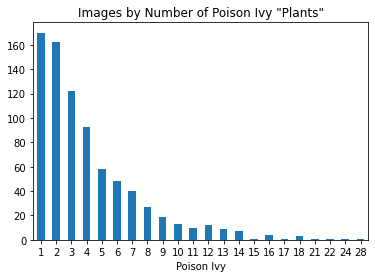

In [7]:
n_objects_df = pd.DataFrame.from_dict(n_objects, orient="index", columns=["Images"]).reset_index().sort_values("index").rename(columns={"index":"Poison Ivy"}).reset_index(drop=True)
n_objects_df.plot.bar(x="Poison Ivy", y="Images", rot=0, legend=False, title="Images by Number of Poison Ivy \"Plants\"");

In [8]:
display(HTML(n_objects_df.to_html(index=False)))

Poison Ivy,Images
1,170
2,162
3,122
4,93
5,58
6,48
7,40
8,27
9,19
10,13


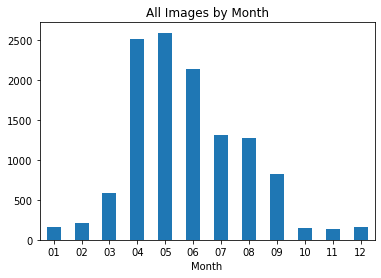

In [9]:
all_month_counts_df = pd.DataFrame.from_dict(all_month_counts, orient="index", columns=["Images"]).reset_index().sort_values("index").rename(columns={"index":"Month"}).reset_index(drop=True)
all_month_counts_df.plot.bar(x="Month", y="Images", rot=0, legend=False, title="All Images by Month");

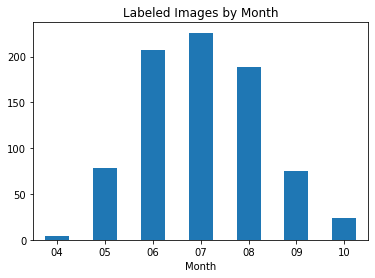

In [10]:
month_counts_df = pd.DataFrame.from_dict(month_counts, orient="index", columns=["Images"]).reset_index().sort_values("index").rename(columns={"index":"Month"}).reset_index(drop=True)
month_counts_df.plot.bar(x="Month", y="Images", rot=0, legend=False, title="Labeled Images by Month");

In [11]:
month_counts_df

,Month,Images
0,04,4
1,05,78
2,06,207
3,07,226
4,08,189
5,09,75
6,10,24


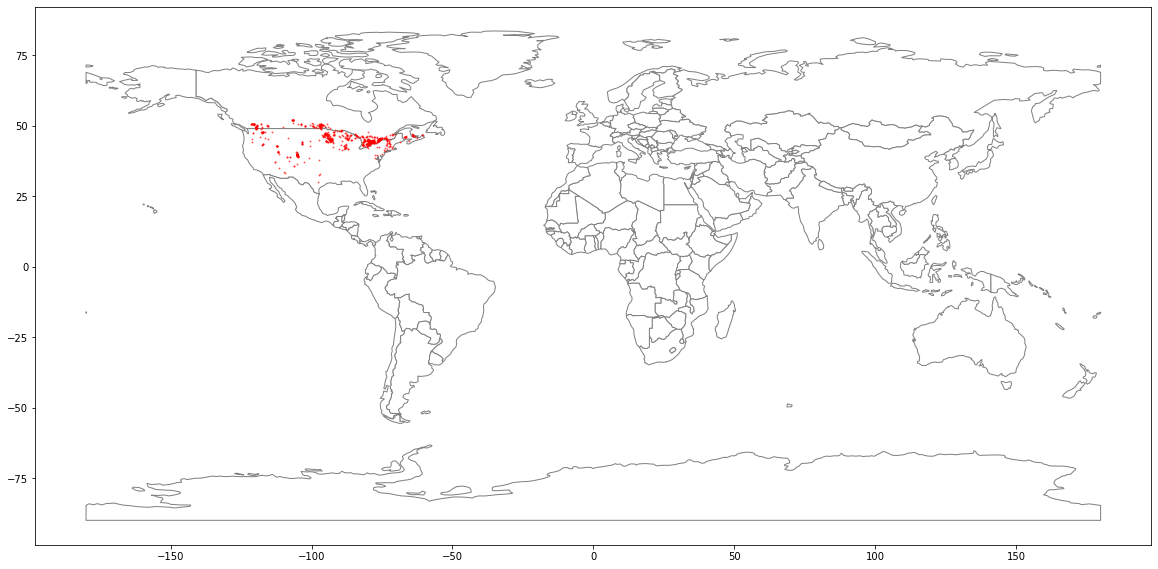

In [12]:
plt.rcParams["figure.figsize"] = 20, 20
coords_df = pd.DataFrame(coords)
gdf = gpd.GeoDataFrame(coords_df, geometry=gpd.points_from_xy(coords_df.lon, coords_df.lat))
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
ax = world.plot(color="white", edgecolor="gray")
gdf.plot(ax=ax, color="red", markersize=1, alpha=0.5)
plt.show()

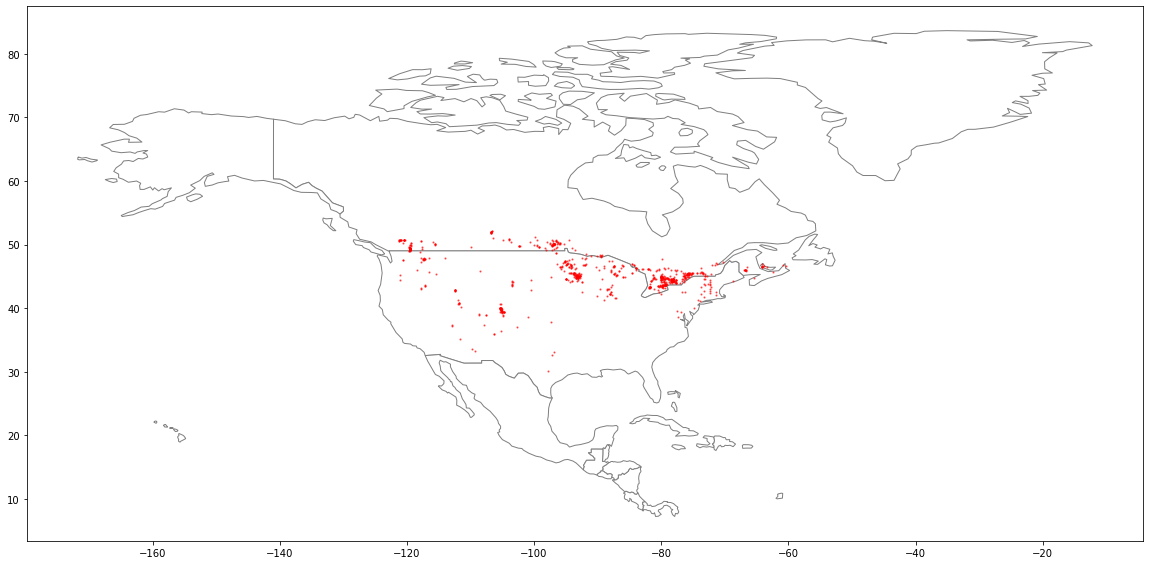

In [13]:
north_america = world[world.continent == "North America"].plot(color="white", edgecolor="gray")
gdf.plot(ax=north_america, color="red", markersize=1.5, alpha=0.5)
plt.show()

In [14]:
max_record

73824